# DirectView as multiplexer

In [ ]:
import os,sys,time
import numpy as np

from IPython.display import display
import ipyparallel as ipp
rc = ipp.Client()

The DirectView can be readily understood as an Engine Multiplexer -
it does the same thing on all of its engines.

The only difference between running code on a single remote engine
and running code in parallel is how many engines the DirectView is
instructed to use.

You can create DirectViews by index-access to the Client.  This creates
a DirectView using the engines after passing the same index (or slice)
to the `ids` list.

In [ ]:
e0 = rc[0]
engines = rc[:]
even = rc[::2]
odd = rc[1::2]

# this is the one we are going to use:
dview = engines
dview.block = True

Now, the only difference from single-engine remote execution is that the code we run happens on all of the engines of a given view:

In [ ]:
for view in (e0, engines, even, odd):
    print(view, view.apply_sync(os.getpid))

The results of multiplexed execution is always a list of the length of the number of engines.

In [ ]:
engines['a'] = 5
engines['a']

In [ ]:
%%px
import os
pid = os.getpid()

In [ ]:
engines.targets

In [ ]:
backwards = rc[::-1]
backwards

In [ ]:
backwards['pid']

In [ ]:
engines['pid']

# Scatter and Gather

Lots of parallel computations involve partitioning data onto processes.  
DirectViews have `scatter()` and `gather()` methods, to help with this.
Pass any container or numpy array, and IPython will partition the object onto the engines wih `scatter`,
or reconstruct the full object in the Client with `gather()`.

In [27]:
dview.scatter('a', list(range(16)))
dview['a']

[[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14, 15]]

In [28]:
dview.gather('a')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [29]:
dview.execute("asum = sum(a)")
sums = dview.gather('asum')
sums

[6, 22, 38, 54]

In [30]:
sum(sums)

120

We can pass a 'flatten' keyword,
to instruct engines that will only get one item of the list to
get the actual item, rather than a one-element sublist:

In [31]:
dview.scatter('id', rc.ids)
dview['id']

[[0], [1], [2], [3]]

In [32]:
dview.scatter('id', rc.ids, flatten=True)
dview['id']

[0, 1, 2, 3]

Scatter and gather also work with numpy arrays

In [33]:
A = np.random.randint(1,10,(16,4))
B = np.random.randint(1,10,(4,16))
display(A)
display(B)

array([[3, 2, 3, 7],
       [9, 1, 5, 9],
       [2, 3, 5, 9],
       [2, 3, 7, 9],
       [1, 4, 7, 8],
       [9, 4, 3, 2],
       [7, 3, 3, 9],
       [4, 4, 4, 2],
       [4, 9, 5, 8],
       [9, 2, 9, 1],
       [4, 1, 1, 1],
       [3, 4, 5, 4],
       [4, 5, 2, 6],
       [7, 2, 6, 2],
       [9, 5, 4, 2],
       [6, 2, 7, 4]])

array([[4, 5, 5, 8, 2, 4, 7, 9, 8, 1, 8, 8, 3, 9, 4, 7],
       [5, 9, 7, 4, 8, 2, 7, 6, 1, 8, 3, 2, 2, 9, 6, 9],
       [2, 8, 4, 3, 4, 3, 7, 6, 3, 7, 8, 3, 6, 9, 8, 4],
       [2, 4, 7, 2, 1, 8, 4, 6, 2, 2, 5, 4, 1, 2, 8, 9]])

In [61]:
dview.scatter('A', A)
dview.scatter('B', B)
display(e0['A'])
display(e0['B'])

array([[3, 2, 3, 7],
       [9, 1, 5, 9],
       [2, 3, 5, 9],
       [2, 3, 7, 9]])

array([[4, 5, 5, 8, 2, 4, 7, 9, 8, 1, 8, 8, 3, 9, 4, 7]])

In [63]:
for a in engines['A']:
    print(a)

[[3 2 3 7]
 [9 1 5 9]
 [2 3 5 9]
 [2 3 7 9]]
[[1 4 7 8]
 [9 4 3 2]
 [7 3 3 9]
 [4 4 4 2]]
[[4 9 5 8]
 [9 2 9 1]
 [4 1 1 1]
 [3 4 5 4]]
[[4 5 2 6]
 [7 2 6 2]
 [9 5 4 2]
 [6 2 7 4]]


In [64]:
for a in engines['B']:
    print(a)

[[4 5 5 8 2 4 7 9 8 1 8 8 3 9 4 7]]
[[5 9 7 4 8 2 7 6 1 8 3 2 2 9 6 9]]
[[2 8 4 3 4 3 7 6 3 7 8 3 6 9 8 4]]
[[2 4 7 2 1 8 4 6 2 2 5 4 1 2 8 9]]


## Excercise: Parallel Matrix Multiply

Can you compute the Matrix product `C=A.dot(B)` in parallel? (not looking for brilliant, just correct).


In [37]:
C = A.dot(B)
C

array([[ 42,  85,  90,  55,  41,  81,  84,  99,  49,  54,  89,  65,  38,
         86, 104, 114],
       [ 69, 130, 135, 109,  55, 125, 141, 171, 106,  70, 160, 125,  68,
        153, 154, 173],
       [ 51, 113, 114,  61,  57, 101, 106, 120,  52,  79, 110,  73,  51,
        108, 138, 142],
       [ 55, 129, 122,  67,  65, 107, 120, 132,  58,  93, 126,  79,  63,
        126, 154, 150],
       [ 54, 129, 117,  61,  70,  97, 116, 123,  49,  98, 116,  69,  61,
        124, 148, 143],
       [ 66, 113,  99, 101,  64,  69, 120, 135,  89,  66, 118,  97,  55,
        148, 100, 129],
       [ 67, 122, 131,  95,  59, 115, 127, 153,  86,  70, 134, 107,  54,
        135, 142, 169],
       [ 48,  96,  78,  64,  58,  52,  92,  96,  52,  68,  86,  60,  46,
        112,  88,  98],
       [ 87, 173, 159,  99, 108, 113, 158, 168,  72, 127, 139,  97,  68,
        178, 174, 201],
       [ 66, 139, 102, 109,  71,  75, 144, 153, 103,  90, 155, 107,  86,
        182, 128, 126],
       [ 25,  41,  38,  41,  2

In [47]:
A.shape

(16, 4)

In [53]:
A.shape[0]

16

In [54]:
B.shape[1]

16

In [65]:
engines.scatter('test', list(range(10)))
engines['test']

[[0, 1, 2], [3, 4, 5], [6, 7], [8, 9]]

In [66]:
e0['test'] = ['what?']

In [67]:
engines['test']

[['what?'], [3, 4, 5], [6, 7], [8, 9]]

In [68]:
engines.gather('test')

['what?', 3, 4, 5, 6, 7, 8, 9]

In [57]:
import numpy
def rough_matmul(A, B):
    N = A.shape[0]
    M = B.shape[1]
    C = numpy.zeros((N, M))
    for i in range(N):
        for j in range(M):
            C[(i,j)] = A[i].dot(B[:,j])
    return C

In [59]:
def rough_matmul_2(A, B):
    N = A.shape[0]
    M = B.shape[1]
    C = numpy.zeros((N, M))
    for i in range(N):
        C[i,:] = A[i].dot(B)
    return C

In [60]:
rough_matmul_2(A, B)

array([[  42.,   85.,   90.,   55.,   41.,   81.,   84.,   99.,   49.,
          54.,   89.,   65.,   38.,   86.,  104.,  114.],
       [  69.,  130.,  135.,  109.,   55.,  125.,  141.,  171.,  106.,
          70.,  160.,  125.,   68.,  153.,  154.,  173.],
       [  51.,  113.,  114.,   61.,   57.,  101.,  106.,  120.,   52.,
          79.,  110.,   73.,   51.,  108.,  138.,  142.],
       [  55.,  129.,  122.,   67.,   65.,  107.,  120.,  132.,   58.,
          93.,  126.,   79.,   63.,  126.,  154.,  150.],
       [  54.,  129.,  117.,   61.,   70.,   97.,  116.,  123.,   49.,
          98.,  116.,   69.,   61.,  124.,  148.,  143.],
       [  66.,  113.,   99.,  101.,   64.,   69.,  120.,  135.,   89.,
          66.,  118.,   97.,   55.,  148.,  100.,  129.],
       [  67.,  122.,  131.,   95.,   59.,  115.,  127.,  153.,   86.,
          70.,  134.,  107.,   54.,  135.,  142.,  169.],
       [  48.,   96.,   78.,   64.,   58.,   52.,   92.,   96.,   52.,
          68.,   86.,   60

In [44]:
A[0]

array([3, 2, 3, 7])

In [45]:
B[:,0]

array([4, 5, 2, 2])

In [46]:
A[0].dot(B[:,0])

42

In [38]:
%run ../hints
mmhint()

In [70]:
# %load ../soln/matmul.py
def pdot(v, A, B):
    v['B'] = B # push B everywhere
    v.scatter('A', A) # scatter A
    v.execute('C=A.dot(B)') # compute the dot-product
    return v.gather('C', block=True) # gather the resulting sub-arrays


Let's run this, and validate the result against a local computation.

In [71]:
C_ref = A.dot(B)
C1 = pdot(dview, A, B)
# validation:
(C1==C_ref).all()

True

# Map

DirectViews have a map method that behaves just like the builtin map
but computed in parallel.

In [72]:
dview.block = True

serial_result   =  list(map(lambda x:x**10, range(32)))
parallel_result = dview.map(lambda x:x**10, range(32))

serial_result == parallel_result

True

In [73]:
parallel_result

[0,
 1,
 1024,
 59049,
 1048576,
 9765625,
 60466176,
 282475249,
 1073741824,
 3486784401,
 10000000000,
 25937424601,
 61917364224,
 137858491849,
 289254654976,
 576650390625,
 1099511627776,
 2015993900449,
 3570467226624,
 6131066257801,
 10240000000000,
 16679880978201,
 26559922791424,
 41426511213649,
 63403380965376,
 95367431640625,
 141167095653376,
 205891132094649,
 296196766695424,
 420707233300201,
 590490000000000,
 819628286980801]

`DirectView.map` partitions the sequences onto each engine,
and then calls `map` remotely.  The result is always a single
IPython task per engine.

In [74]:
amr = dview.map_async(lambda x:x**10, range(32))
amr.msg_ids

['9c73b4a0-9fd4a47204e80d02f20270c3',
 'e44485a9-9d068162f4cd157122f24f41',
 '85ceac23-a621feefb587be74a15c652e',
 '00316bbe-ddf9dbf7a5602eb532a8be8c']

In [75]:
amr = dview.map_async(lambda x:x**10, range(3200))
amr.msg_ids

['d2a89361-002c80f015fe7674e3ac137c',
 '4ccf9420-604145de8971ef6a597f7184',
 'a382c813-c745dbedb7b9c62d0894b23f',
 '8188668c-600e970c42c4e98b5a5d0f86']

In [76]:
amr.get()

[0,
 1,
 1024,
 59049,
 1048576,
 9765625,
 60466176,
 282475249,
 1073741824,
 3486784401,
 10000000000,
 25937424601,
 61917364224,
 137858491849,
 289254654976,
 576650390625,
 1099511627776,
 2015993900449,
 3570467226624,
 6131066257801,
 10240000000000,
 16679880978201,
 26559922791424,
 41426511213649,
 63403380965376,
 95367431640625,
 141167095653376,
 205891132094649,
 296196766695424,
 420707233300201,
 590490000000000,
 819628286980801,
 1125899906842624,
 1531578985264449,
 2064377754059776,
 2758547353515625,
 3656158440062976,
 4808584372417849,
 6278211847988224,
 8140406085191601,
 10485760000000000,
 13422659310152401,
 17080198121677824,
 21611482313284249,
 27197360938418176,
 34050628916015625,
 42420747482776576,
 52599132235830049,
 64925062108545024,
 79792266297612001,
 97656250000000000,
 119042423827613001,
 144555105949057024,
 174887470365513049,
 210832519264920576,
 253295162119140625,
 303305489096114176,
 362033331456891249,
 430804206899405824,
 511116

### The motivating example

In [77]:
%run ../images_common
plt.ion()

In [80]:
pictures = get_pictures(os.path.join('..', 'hubble-400x400'))
pictures[:5]

['../hubble-400x400/hubble-00-00.jpg',
 '../hubble-400x400/hubble-00-01.jpg',
 '../hubble-400x400/hubble-00-02.jpg',
 '../hubble-400x400/hubble-00-03.jpg',
 '../hubble-400x400/hubble-00-04.jpg']

In [79]:
# %px cd {os.getcwd()}

rc[:].apply_sync(os.chdir, os.getcwd())

[None, None, None, None]

In [81]:
%%px

from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import blob_doh

   1/1 tasks finished after    0 s
done


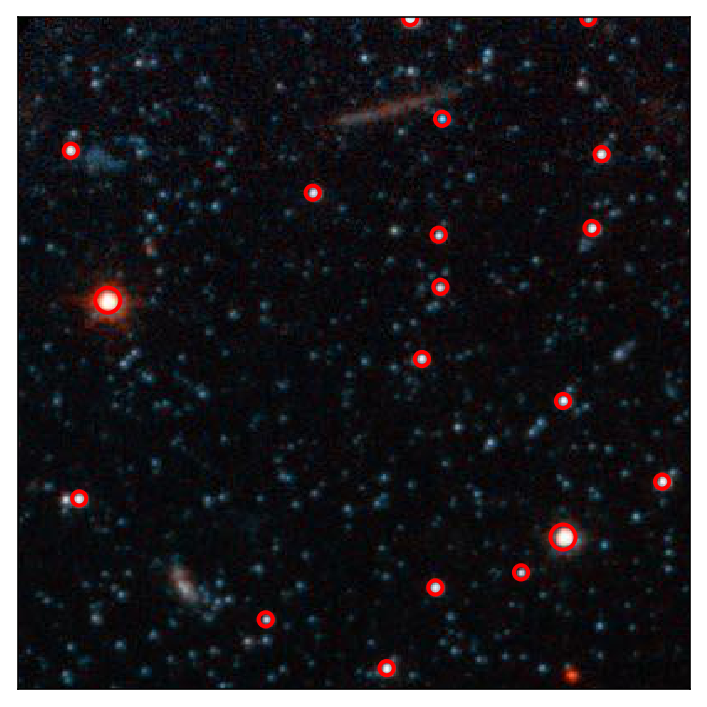

In [82]:
ar = e0.apply_async(find_blobs, pictures[0])
ar.wait_interactive()
plot_blobs(*ar.get())

   4/4 tasks finished after    0 s
done


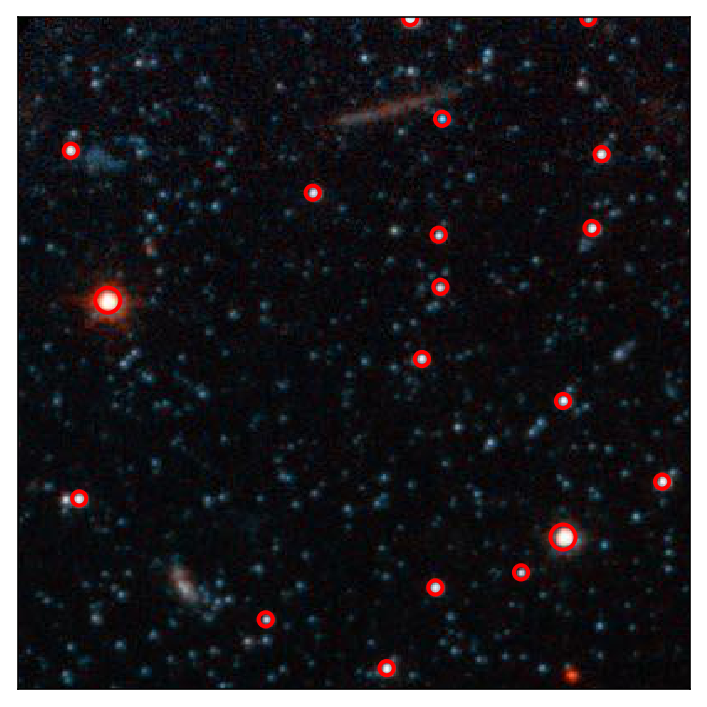

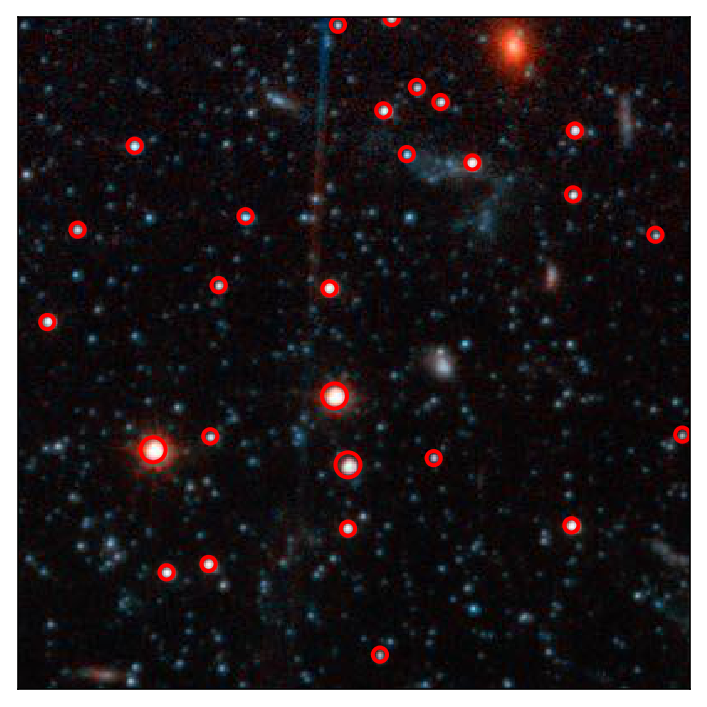

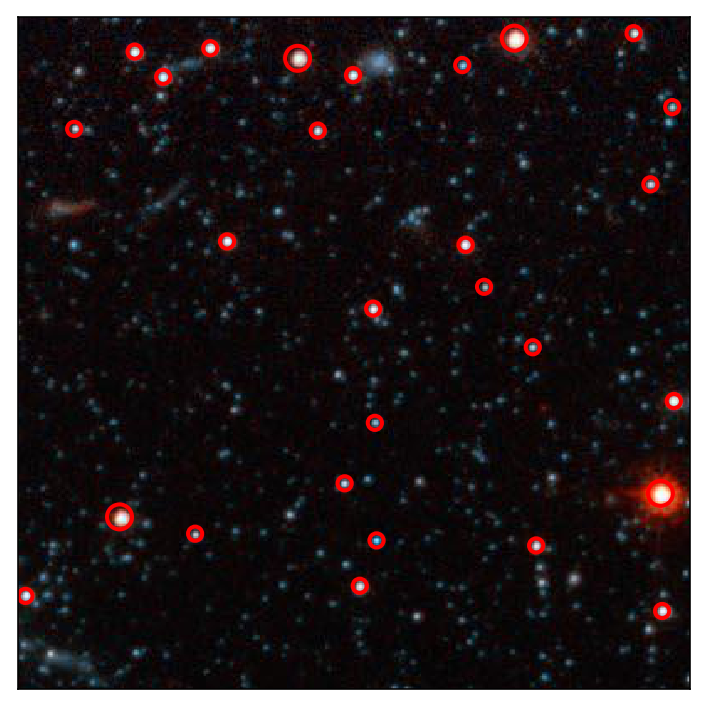

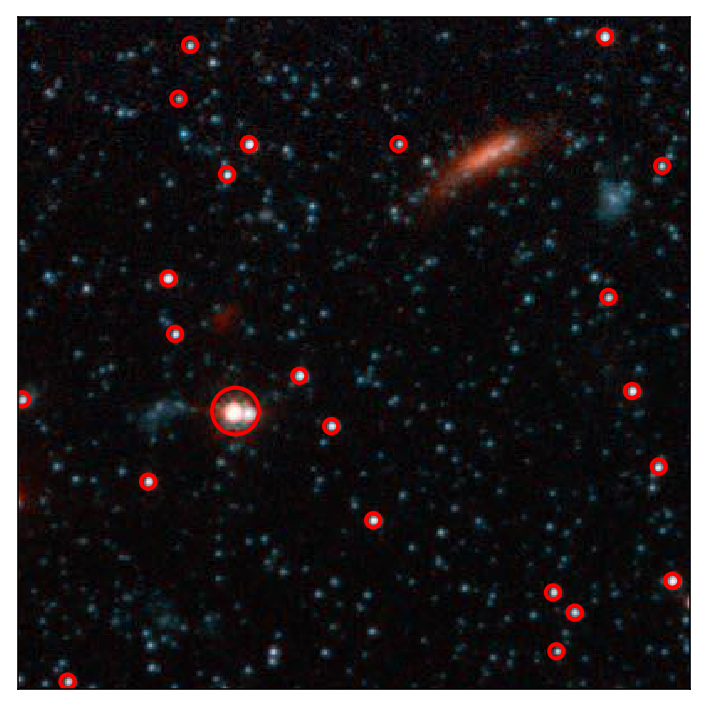

In [83]:
amr = engines.map_async(find_blobs, pictures[:len(engines)])
amr.wait_interactive()
for img, blobs in amr:
    plot_blobs(img, blobs)


## Exercises and Examples

- [Remote Iteration](../exercises/Remote%20Iteration.ipynb)
- [Monte Carlo π](../exercises/Monte%20Carlo%20π.ipynb)

# Moving on

IPython.parallel can also be used for [load-balanced execution](Load-Balancing.ipynb),
when you just want code to run, but don't care where.